In [20]:
import pandas as pd
import re
from sklearn.model_selection import ShuffleSplit
import numpy as np

merged_data = pd.read_csv("merged_dataset.csv",index_col=False)
drug_data =  pd.read_csv("morgan_fp_drug_128.csv")
protein_data =  pd.read_csv("protein_desc_mutant.csv")
merged_data = merged_data.merge(drug_data, left_on=['drug'], right_on=['drug'])
merged_data = merged_data.merge(protein_data, left_on=['mutant'], right_on=['mutant'])
df = merged_data.iloc[:,1:]

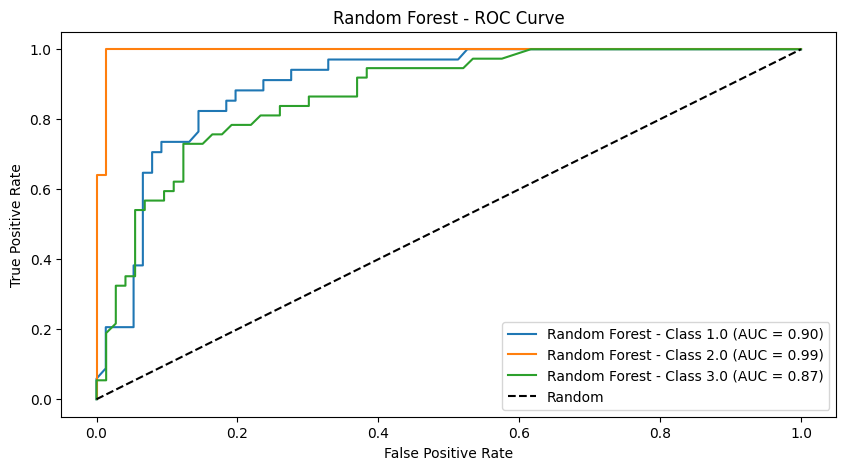

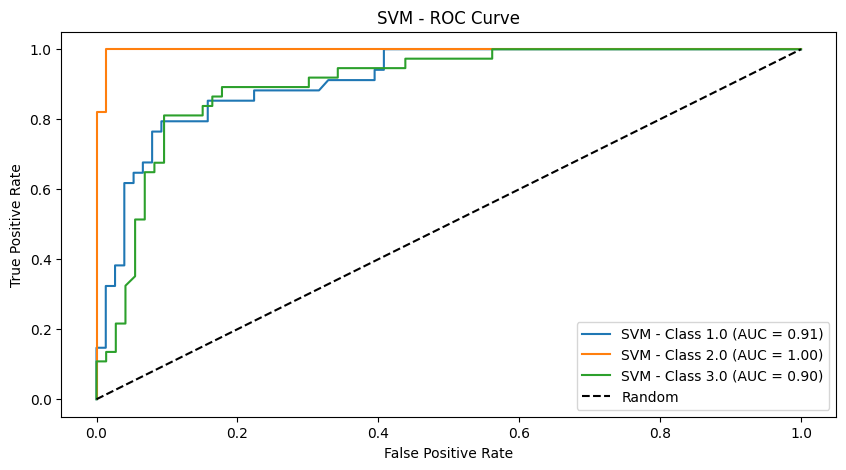

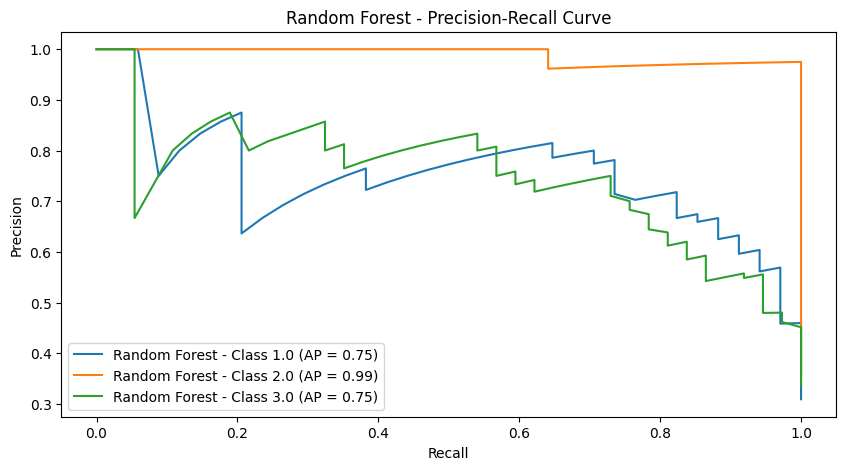

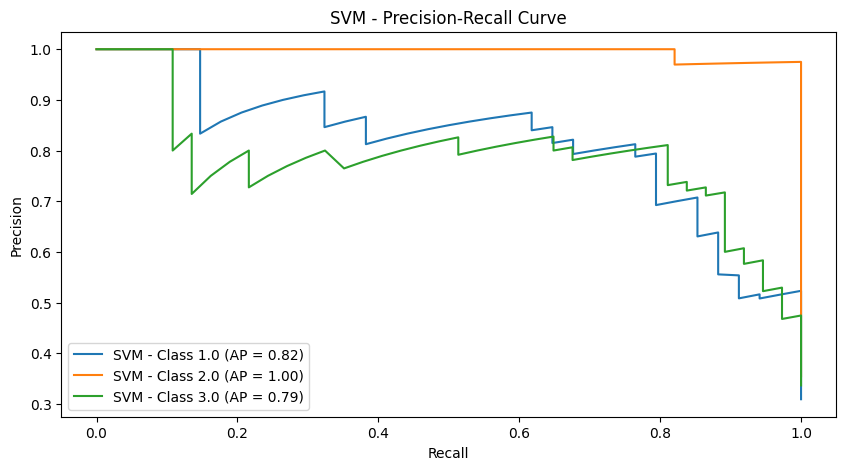

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame containing the features and target

X = df.iloc[:, 3:].values  # All columns from the 4th column onwards (morgan features)
y = df['trend'].values     # Target is the 'trend' column

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA with 64 components
pca = PCA(n_components=64)
X_pca = pca.fit_transform(X_scaled)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Resampling using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)


# --- Train Random Forest Model ---
def train_rf_model(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    all_true_labels = y_test
    all_pred_probs = rf_model.predict_proba(X_test)
    return all_true_labels, all_pred_probs

# --- Train SVM Model ---
def train_svm_model(X_train, X_test, y_train, y_test):
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    all_true_labels = y_test
    all_pred_probs = svm_model.predict_proba(X_test)
    return all_true_labels, all_pred_probs

# Train and evaluate Random Forest and SVM models
rf_true_labels, rf_pred_probs = train_rf_model(X_train, X_test, y_train, y_test)
svm_true_labels, svm_pred_probs = train_svm_model(X_train, X_test, y_train, y_test)

# --- ROC and Precision-Recall plots ---

def plot_roc_curve(true_labels, pred_probs, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(true_labels, pred_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 5))
    for i in range(len(le.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'{model_name} - Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, pred_probs, model_name):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(len(le.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(true_labels, pred_probs[:, i], pos_label=i)
        average_precision[i] = average_precision_score(true_labels == i, pred_probs[:, i])

    plt.figure(figsize=(10, 5))
    for i in range(len(le.classes_)):
        plt.plot(recall[i], precision[i], label=f'{model_name} - Class {le.classes_[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC and Precision-Recall for each model
plot_roc_curve(rf_true_labels, rf_pred_probs, 'Random Forest')
plot_roc_curve(svm_true_labels, svm_pred_probs, 'SVM')

plot_precision_recall_curve(rf_true_labels, rf_pred_probs, 'Random Forest')
plot_precision_recall_curve(svm_true_labels, svm_pred_probs, 'SVM')
